<a href="https://colab.research.google.com/github/IANGECHUKI176/deeplearning/blob/main/pytorch/nlp/karpathy/makemore_part3_bn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
words = open('names.txt',"r").read().splitlines()
words[:3]

['emma', 'olivia', 'ava']

In [41]:
len(words)

32033

In [42]:
chars  = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
vocab_size

27

In [43]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [44]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_emb),             generator = g)
W1 = torch.randn((n_emb * block_size,n_hidden), generator = g) * (5/3 ) /  ((n_emb * block_size)**0.5)
b1 = torch.randn(n_hidden,                      generator = g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),         generator = g) * 0.01
b2 = torch.randn(vocab_size,                    generator= g) * 0
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))

bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C,W1,b1,W2,b2,bngain,bnbias]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


12297


In [45]:
(torch.randn(10000) * 0.02).std()

tensor(0.0199)

In [46]:
# x = torch.randn(1000,10)
# w = torch.randn(10,200) / 10 ** 0.5
# y = x @ w
# print(x.mean(),x.std())
# print(y.mean(),y.std())
# plt.plot(figsize = (20,5))
# plt.subplot(121)
# plt.hist(x.view(-1).tolist(),50,density  = True)
# plt.subplot(122)
# plt.hist(y.view(-1).tolist(),50,density  = True)
# plt.show()

In [47]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):

    #mini batchsize construct
    ix = torch.randint(0,Xtr.size(0),(batch_size,) , generator =g)
    Xb , Yb = Xtr[ix] , Ytr[ix] # batch X , Y

    #forward pass
    emb = C[Xb] # embed characters into vectors
    embcat = emb.view(emb.size(0),-1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1

    # BatchNorm layer
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0,keepdim = True)
    bnstdi = hpreact.std(0,keepdim = True)
    hpreact = bngain * (hpreact - bnmeani)  /bnstdi  + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    h = torch.tanh(hpreact) #hidden layer

    logits = h @ W2 + b2 #output layer

    loss = F.cross_entropy(logits,Yb) #loss

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad


    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

TypeError: ignored

In [ ]:
plt.hist(hpreact.view(-1).tolist(),50)
plt.show()

In [ ]:
plt.figure(figsize = (20,20))
plt.imshow(hpreact.abs() > 0.99 ,cmap ='gray', interpolation = 'nearest')

In [ ]:
-torch.tensor(1/27).log()

In [ ]:
plt.plot(lossi)

In [ ]:
with torch.no_grad():
    emb = C[Xtr] #[N,block_size,n_emb]
    embcat = emb.view(emb.size(0),-1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0,keepdim = True)
    bnstd = hpreact.std(0,keepdim = True)

In [ ]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        "train": {Xtr,Ytr},
        "val" : {Xdev , Ydev},
        "test" : {Xte,Yte}
    }[split]

    emb = C[x] #[N,block_size,n_emb]
    embcat = emb.view(emb.size(0),-1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1

    hpreact = bngain * (hpreact - bnmean)  / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 #[N,vocab_size]
    loss = F.cross_entropy(logits,y)
    print(split,loss)

split_loss('train')
split_loss('val')

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:

        emb = C[torch.tensor(context)]
        embcat = emb.view(1,-1)
        h = torch.tanh(embcat @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim = 1)

        ix = torch.multinomial(probs,num_samples= 1,generator = g).item()
        context = context[1:] + [ix]

        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))


PyTorchify Code

In [185]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self,dim ,eps = 1e-5 , momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers trained with a momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self,x):
        #calculate forward pass
        if self.training:
            xmean = x.mean(0,keepdim = True) #batch mean
            xvar = x.var(0,keepdim = True) #batch var
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma,self.beta]


class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility


C = torch.randn((vocab_size,n_embd),               generator =g)
layers = [
    Linear(n_embd * block_size,n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden,n_hidden),BatchNorm1d(n_hidden) ,Tanh(),
    Linear(           n_hidden,n_hidden),BatchNorm1d(n_hidden) ,Tanh(),
    Linear(           n_hidden,n_hidden),BatchNorm1d(n_hidden) ,Tanh(),
    Linear(           n_hidden,n_hidden),BatchNorm1d(n_hidden) ,Tanh(),
    Linear(n_hidden,vocab_size),BatchNorm1d(vocab_size)
]
with torch.no_grad():
  # last layer: make less confident
  #[-1].weight *= 0.1
  layers[-1].gamma *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47551


In [193]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 2.0543


layer 2 (      Tanh): mean -0.04, std 0.65, saturated: 3.84%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 3.84%
layer 8 (      Tanh): mean +0.01, std 0.67, saturated: 2.84%
layer 11 (      Tanh): mean +0.01, std 0.67, saturated: 2.38%
layer 14 (      Tanh): mean -0.03, std 0.68, saturated: 1.97%


Text(0.5, 1.0, 'activation distribution')

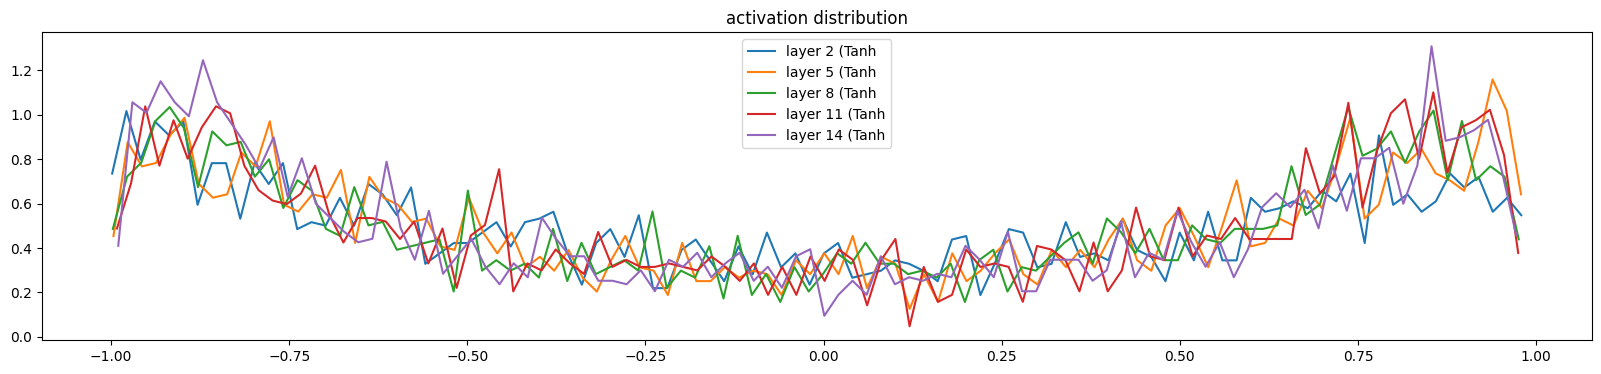

In [194]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000079, std 1.993154e-03
layer 5 (      Tanh): mean -0.000049, std 1.735239e-03
layer 8 (      Tanh): mean +0.000002, std 1.659224e-03
layer 11 (      Tanh): mean -0.000033, std 1.660079e-03
layer 14 (      Tanh): mean -0.000080, std 1.822034e-03


Text(0.5, 1.0, 'gradient distribution')

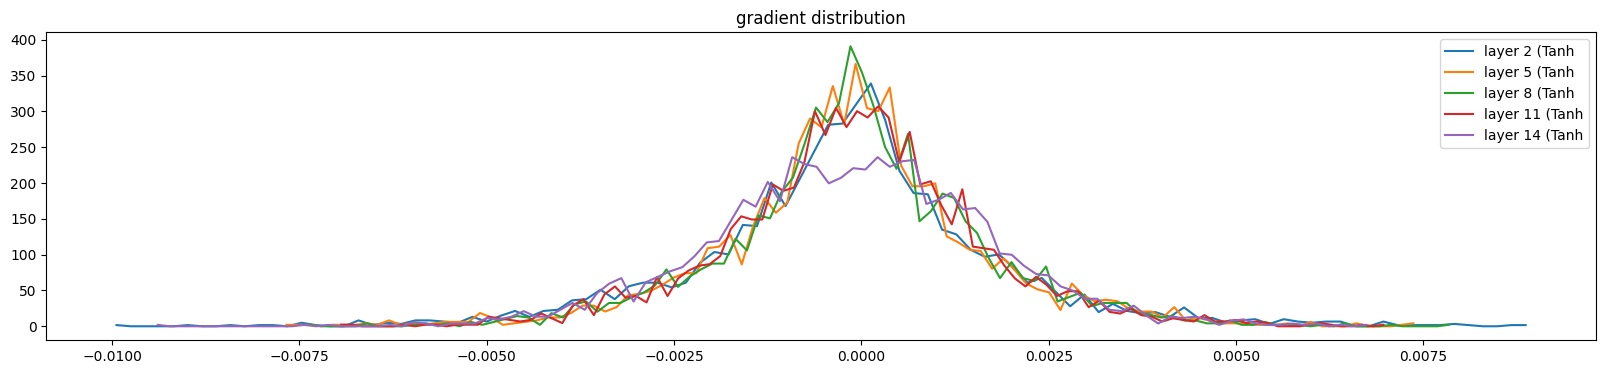

In [195]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000674 | std 7.658056e-03 | grad:data ratio 7.456247e-03
weight  (30, 100) | mean +0.000117 | std 4.640808e-03 | grad:data ratio 1.384301e-02
weight (100, 100) | mean -0.000020 | std 2.659038e-03 | grad:data ratio 1.443471e-02
weight (100, 100) | mean -0.000015 | std 2.390967e-03 | grad:data ratio 1.323435e-02
weight (100, 100) | mean +0.000021 | std 2.260485e-03 | grad:data ratio 1.265886e-02
weight (100, 100) | mean +0.000041 | std 2.322279e-03 | grad:data ratio 1.299861e-02
weight  (100, 27) | mean +0.000026 | std 5.947610e-03 | grad:data ratio 2.722594e-02


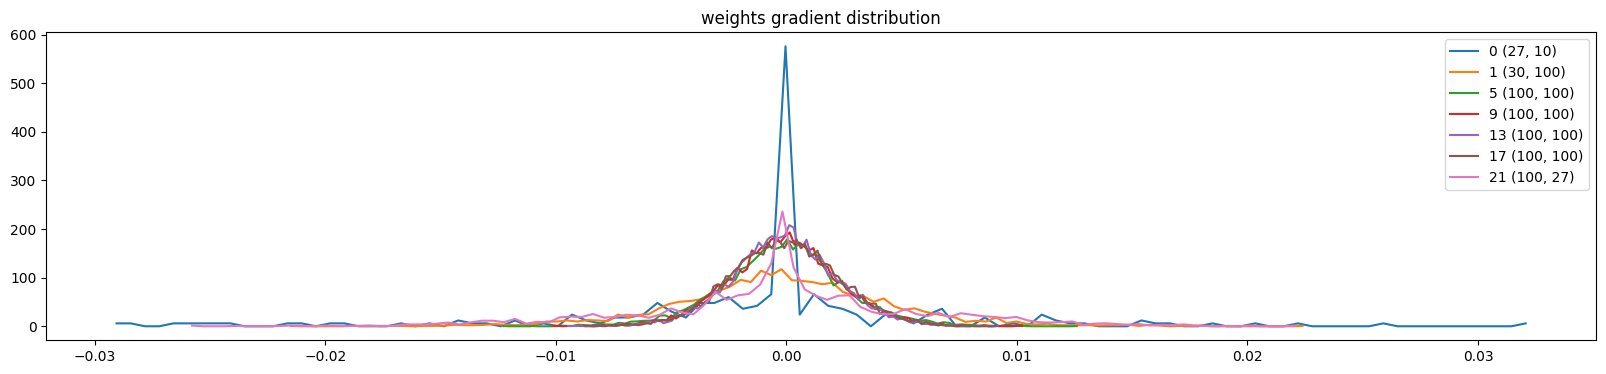

In [196]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

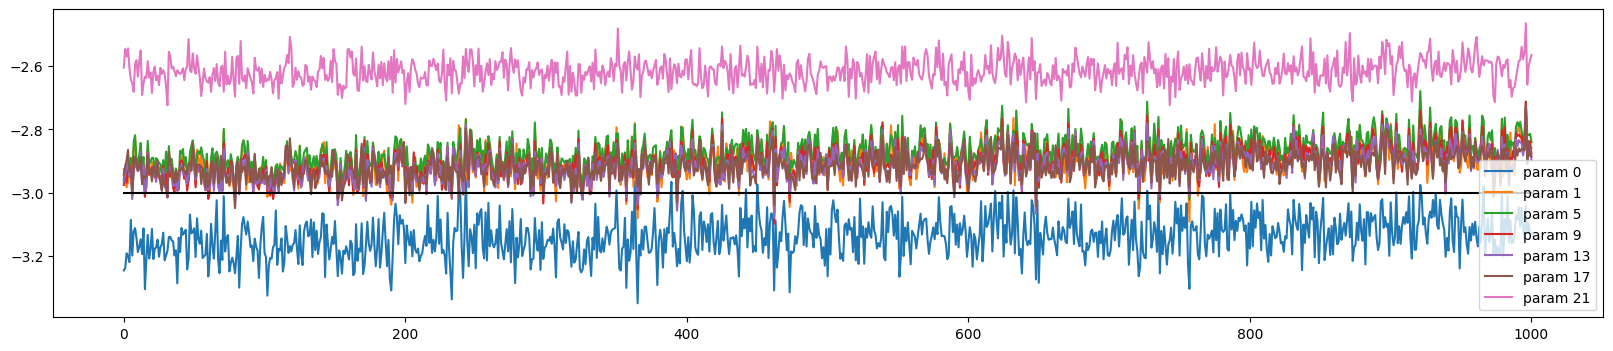

In [197]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [198]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        "train": {Xtr,Ytr},
        "val" : {Xdev , Ydev},
        "test" : {Xte,Yte}
    }[split]

    emb = C[x] #[N,block_size,n_emb]
    x = emb.view(emb.size(0),-1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x,y)
    print(split,loss)

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train tensor(2.2855)
val tensor(2.2858)


In [199]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        emb = C[torch.tensor(context)]  # (1,block_size,n_embd)
        x = emb.view(1,-1)  # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs,num_samples= 1,generator = g).item()
        context = context[1:] + [ix]

        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mria.
kmyanniee.
med.
ryah.
rethretendrlee.
aderedielii.
shi.
jen.
eden.
vana.
arlelyn.
mhona.
cayshubergihiriest.
jajewellelanthulanu.
zengder.
yah.
faeh.
ylah.
mystolen.
hil.
